### Installations
This cell installs all the libraries necessary for the notebook:

In [1]:
!pip install datasets
!pip install nltk
import nltk
!pip install gensim
!pip install tensorflow


### Loading Dataset as DF
This cell loads the Stanford Sentiment Treebank (SST-2) dataset using the Hugging Face `datasets` library. The SST-2 dataset is part of the GLUE benchmark and contains sentences labeled as either positive or negative sentiment. It then converts the training split into a pandas DataFrame called `df` for easier manipulation and preprocessing.

- `sentence` column: Contains the raw text data.
- `label` column: 0 = negative sentiment, 1 = positive sentiment.


In [2]:
from datasets import load_dataset
import pandas as pd

dataset = load_dataset("glue", "sst2")
df = pd.DataFrame(dataset['train'])



### Text Preprocessing
This cell defines a custom text preprocessing function called `preprocess_text` that performs the following:

1. Lowercasing the text.
2. Removing non-alphabetic characters.
3. Tokenizing the cleaned text into words.
4. Removing stopwords.
5. Lemmatizing each word to its root form.

The function returns a cleaned string of lemmatized tokens which are ready for feature extraction.


In [3]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    
    text = re.sub(r'[^a-z\s]', '', text)
    
    tokens = word_tokenize(text)
    
    cleaned = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    return ' '.join(cleaned)


In [4]:
import nltk
import os

nltk_data_dir = os.path.join(os.getcwd(), 'nltk_data')
os.makedirs(nltk_data_dir, exist_ok=True)

nltk.download('popular')



[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     C:\Users\krish/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     C:\Users\krish/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     C:\Users\krish/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     C:\Users\krish/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     C:\Users\krish/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     C:\Users\krish/nltk_data...
[nltk_data]    |   Package movie_reviews is a

True

In [5]:
import os
import nltk


nltk_data_path = os.path.join(os.getcwd(), "nltk_data")


os.makedirs(nltk_data_path, exist_ok=True)


nltk.data.path.append(nltk_data_path)


nltk.download("popular", download_dir=nltk_data_path)


nltk.data.path.append(nltk_data_dir)
nltk.download('punkt_tab', download_dir=nltk_data_path)


[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     C:\Users\krish\nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     C:\Users\krish\nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     C:\Users\krish\nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     C:\Users\krish\nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     C:\Users\krish\nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     C:\Users\krish\nltk_data...
[nltk_data]    |   Package movie_reviews is a

True

### Modifying DF
This applies the `preprocess_text` function to every sentence in the dataset.

- A new column `cleaned_sentence` is created.
- Each sentence is tokenized, lowercased, stripped of stopwords/punctuation, and lemmatized.

This cleaned version of text will be used as input to the TF-IDF, CountVectorizer, and Word2Vec models for improved learning performance.


In [6]:
df['cleaned_sentence'] = df['sentence'].apply(preprocess_text)
df[['sentence', 'cleaned_sentence']].head()


,sentence,cleaned_sentence
0,hide new secretions from the parental units,hide new secretion parental unit
1,"contains no wit , only labored gags",contains wit labored gag
2,that loves its characters and communicates som...,love character communicates something rather b...
3,remains utterly satisfied to remain the same t...,remains utterly satisfied remain throughout
4,on the worst revenge-of-the-nerds clichés the ...,worst revengeofthenerds clichs filmmaker could...


This imports the `TfidfVectorizer` class from scikit-learn.


In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer


### TF-IDF matrix implementation
This cell transforms the cleaned text into numerical features using TF-IDF.

Key points:
- `TfidfVectorizer(max_features=5000)` limits the vocabulary to the top 5000 words by frequency.
- `fit_transform(...)` does two things:
   1. Learns the vocabulary and IDF statistics from the data.
   2. Transforms each document into a sparse vector representation.

The output `X` is a sparse matrix of shape (num_samples, num_features) where each row corresponds to a sentence.


In [8]:
vectorizer = TfidfVectorizer(max_features=5000)  
X = vectorizer.fit_transform(df['cleaned_sentence'])  


In [9]:
print("TF-IDF Matrix Shape:", X.shape)  


TF-IDF Matrix Shape: (67349, 5000)


### TF-IDF & Logistic Regression
This is the first machine learning model training step:

- `train_test_split(...)`: Splits the TF-IDF vectors and labels into training (80%) and testing (20%) sets.
- `LogisticRegression(...)`: Initializes a logistic regression classifier for binary classification (positive/negative).
- `model.fit(...)`: Trains the model on the training data.
- `model.predict(...)`: Predicts labels for the test set.
- `classification_report(...)`: Prints precision, recall, f1-score, and accuracy.

This baseline model helps evaluate how well TF-IDF features alone perform on sentiment classification.


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, df['label'], test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.86      0.80      0.83      5909
           1       0.85      0.90      0.87      7561

    accuracy                           0.85     13470
   macro avg       0.85      0.85      0.85     13470
weighted avg       0.85      0.85      0.85     13470



In [11]:
import joblib

# Save to the current working directory
joblib.dump(model, "Logistic_Regression_TF_IDF.pkl")
joblib.dump(vectorizer, "vectorizer.pkl")



['vectorizer.pkl']

### Building Count Vectorizer
This cell replaces TF-IDF with a simpler `CountVectorizer`, which:

- Counts the raw number of times each word appears in a sentence (term frequency).
- `max_features=5000`: Limits vocabulary to top 5000 most frequent words.

Unlike TF-IDF, it does not weight terms by their uniqueness across the dataset.



In [12]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=5000)  
X_counts = vectorizer.fit_transform(df['cleaned_sentence'])  


In [13]:
print("Count Vectorizer Shape:", X_counts.shape)
print("Sample features:", vectorizer.get_feature_names_out()[:10])


Count Vectorizer Shape: (67349, 5000)
Sample features: ['abandon' 'abc' 'ability' 'able' 'abomination' 'abroad' 'absolute'
 'absolutely' 'absorbing' 'abstract']


### Count Vectorizer and Logistic Regression
This cell repeats the same classification workflow, but this time using the `CountVectorizer` representation instead of TF-IDF.

Steps:
- The count-based features (`X_counts`) and labels are split into training and test sets.
- A `LogisticRegression` model is trained on raw word counts.
- Predictions are made on the test set.

This helps compare whether **TF-IDF** or **CountVectorizer** works better on the same logistic regression model.


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X_counts, df['label'], test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.86      0.80      0.83      5909
           1       0.85      0.90      0.88      7561

    accuracy                           0.86     13470
   macro avg       0.86      0.85      0.85     13470
weighted avg       0.86      0.86      0.86     13470



In [15]:
import joblib


joblib.dump(model, "Logistic_regression_CountVectorizer.pkl")


joblib.dump(X_counts, "Count_vectorizer.pkl")


['Count_vectorizer.pkl']

### Naive Bayes with CountVectorizer

This cell implements a **Multinomial Naive Bayes** classifier using the previously generated `CountVectorizer` features (`X_counts`), which represent each sentence as a bag-of-words.

- Perform a train-test split on the vectorized data (`X_counts`) and labels (`df["label"]`).
- I then instantiate and train a `MultinomialNB` model on the training data.
- Finally, the model is tested on the test set and evaluated using accuracy and a full classification report showing precision, recall, and F1-score for both classes.

This approach is particularly well-suited for text classification tasks like sentiment analysis, where word frequencies help inform the class prediction.


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report


y = df["label"]


X_train_vec, X_test_vec, y_train, y_test = train_test_split(
    X_counts, y, test_size=0.2, random_state=42
)


nb = MultinomialNB()
nb.fit(X_train_vec, y_train)


y_pred_nb = nb.predict(X_test_vec)
print("Accuracy:", round(accuracy_score(y_test, y_pred_nb) * 100, 2), "%")
print("Classification Report:\n", classification_report(y_test, y_pred_nb))




Accuracy: 83.66 %
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.79      0.81      5909
           1       0.84      0.88      0.86      7561

    accuracy                           0.84     13470
   macro avg       0.84      0.83      0.83     13470
weighted avg       0.84      0.84      0.84     13470



In [17]:
import joblib


joblib.dump(nb, "naive_bayes_model.pkl")






['naive_bayes_model.pkl']

In [18]:

accuracy = accuracy_score(y_test, y_pred_nb)
print("Test Accuracy of Naive Bayes Model:", round(accuracy * 100, 2), "%")


Test Accuracy of Naive Bayes Model: 83.66 %


In [19]:
from nltk.tokenize import word_tokenize

tokenized_sentences = df['cleaned_sentence'].apply(word_tokenize).tolist()


### Word2Vec Model
This trains a **Word2Vec** model using the tokenized sentences.

Key parameters:
- `vector_size=100`: Each word will be embedded into a 100-dimensional vector.
- `window=5`: The context window size — how many words left/right are considered for learning relationships.
- `min_count=2`: Ignores words that appear fewer than 2 times.
- `workers=4`: Uses 4 threads for training.
- `sg=1`: Trains using the **Skip-gram** model (sg=0 would use CBOW instead).

The model learns **semantic relationships** between words — placing similar words closer in vector space.


In [20]:
from gensim.models import Word2Vec

w2v_model = Word2Vec(
    sentences=tokenized_sentences,
    vector_size=100,     
    window=5,            
    min_count=2,         
    workers=4,           
    sg=1                 
)


In [21]:
w2v_model.save("word2vec_model.model")


In [22]:

print(w2v_model.wv['good'])


print(w2v_model.wv.most_similar('bad'))


print("Embedding size:", w2v_model.wv['good'].shape)


[-0.82304484  1.1755512  -0.05508855  0.5576878   0.4710792  -0.21810113
  0.69730794  0.18274051 -0.7185461   0.01138625  0.11362801 -0.71721685
  0.5421661  -0.24904343  0.65187377 -0.68611646 -0.3524344  -0.18401532
 -0.5685731  -1.0378338   0.11776213  0.71196985  0.3907144  -0.91378725
 -0.80344313 -0.1334065  -0.78283733 -0.16243242 -0.7032204  -0.5418314
  0.7505248   0.02184834  0.24805325  0.02199728  0.10260141  0.33773032
 -0.252815    0.16242409  0.05436249 -0.9740253   0.31982547 -0.22588035
  0.07646509  0.06499834 -0.09602159 -0.11424431 -0.31796148  0.46258706
  0.28816757 -0.08294903  0.5398986   0.06859087 -0.02161387 -0.81946033
 -0.15516156 -0.00623294  0.09830944 -0.07564095  0.32770813 -0.20651871
 -0.28549573 -0.34599316  0.9354577   0.0739391  -0.5199161  -0.04414529
  0.15249163  0.86294234 -0.6163259   0.16286597 -0.587801    0.05961793
  0.64207447  0.8048126  -0.13685699 -0.3112268  -0.19632943 -0.4640826
 -0.9190069  -0.42180836 -0.17603876 -0.37672278  0.2

### Using individual word vectors to transform sentence to Vector
This defines a function `sentence_vector(...)` to convert an entire sentence into a single numeric vector by:

1. Looping through each token in the sentence.
2. Checking if it exists in the Word2Vec model.
3. Averaging all the valid word vectors to create a **fixed-length sentence embedding**.

Then it creates:
- `X_vectors`: A 2D NumPy array where each row is the averaged embedding for a sentence.
- `y`: The corresponding label vector.

These sentence embeddings will be used as input features to train a classifier later.


In [23]:
import numpy as np

def sentence_vector(sentence_tokens, model):
    vectors = [model.wv[word] for word in sentence_tokens if word in model.wv]
    if len(vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)

X_vectors = np.array([sentence_vector(tokens, w2v_model) for tokens in tokenized_sentences])
y = df['label']


In [24]:
print(w2v_model.wv['great'])


[ 1.60561383e-01  1.13387120e+00 -3.57294202e-01  7.22847730e-02
 -2.41528213e-01 -5.03079712e-01  3.82069528e-01  1.24156702e+00
  3.62413168e-01  3.45918611e-02  3.98750812e-01 -6.83767796e-01
  3.25614601e-01  1.95866495e-01 -2.71080226e-01 -1.35708272e-01
 -2.29956992e-02  2.57196903e-01 -1.96339577e-01 -5.95676541e-01
 -1.45237461e-01  9.51184407e-02  2.81944811e-01 -1.17831588e-01
 -1.08825183e+00  4.38186318e-01 -1.26372082e-02 -7.47723401e-01
 -3.79915476e-01 -7.13934243e-01 -3.82553898e-02  1.92682505e-01
  8.62024665e-01 -1.43297315e-02 -5.81139386e-01  7.93198168e-01
  4.15290222e-02 -3.35278153e-01 -8.30194712e-01 -5.78529775e-01
  5.68231106e-01 -9.46287289e-02  3.32215846e-01 -2.82120168e-01
  7.46564806e-01 -3.22744489e-01 -1.24746442e-01  1.15915388e-01
  4.45437133e-01  1.56354249e-01  3.76829691e-02 -7.75181502e-02
 -2.18916193e-01 -5.64881444e-01 -1.29542559e-01 -6.67717159e-02
  2.88936228e-01 -1.58728570e-01  7.70590246e-01 -5.98292232e-01
  8.32867697e-02  1.91251

In [25]:
w2v_model.wv.most_similar('bad', topn=10)


[('indescribably', 0.8146824240684509),
 ('nightmare', 0.7968116998672485),
 ('mindnumbingly', 0.7861451506614685),
 ('operative', 0.7861019968986511),
 ('badder', 0.7846299409866333),
 ('fraction', 0.7805441617965698),
 ('pit', 0.777865469455719),
 ('imitation', 0.7720311284065247),
 ('portion', 0.7701804041862488),
 ('depression', 0.7604833841323853)]

In [26]:
w2v_model.wv.similarity('good', 'great') 
w2v_model.wv.similarity('good', 'terrible')  


0.55295897

### PCA Analysis graph

This cell does the following:

1. Selects the top 100 words from the Word2Vec vocabulary.
2. Extracts their 100-dimensional embedding vectors.
3. Applies PCA (Principal Component Analysis) to reduce them to **2D**.
4. Plots them using matplotlib.

Purpose:
- Visualizes how words are arranged in 2D space.
- Words with similar meanings or usage should appear **closer together**.
- Useful for spotting clusters




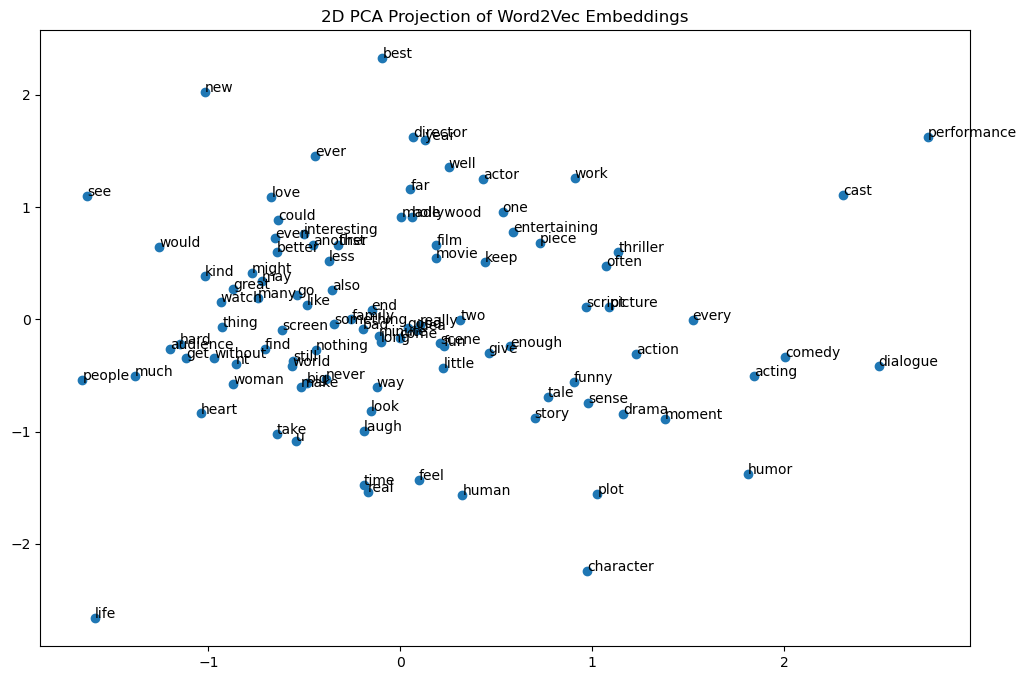

In [27]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


words = list(w2v_model.wv.index_to_key)[:100]  
word_vectors = w2v_model.wv[words]

pca = PCA(n_components=2)
word_vec_2d = pca.fit_transform(word_vectors)


plt.figure(figsize=(12, 8))
plt.scatter(word_vec_2d[:, 0], word_vec_2d[:, 1])

for i, word in enumerate(words):
    plt.annotate(word, xy=(word_vec_2d[i, 0], word_vec_2d[i, 1]))

plt.title("2D PCA Projection of Word2Vec Embeddings")
plt.show()


### Word2Vec & Logistic Regression
This cell trains a Logistic Regression classifier using the sentence-level vectors created 




In [28]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


X_train, X_test, y_train, y_test = train_test_split(X_vectors, y, test_size=0.2, random_state=42)


model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)


print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.69      0.69      0.69      5909
           1       0.76      0.76      0.76      7561

    accuracy                           0.73     13470
   macro avg       0.73      0.73      0.73     13470
weighted avg       0.73      0.73      0.73     13470



In [29]:
joblib.dump(model, "Logistic_regression_Wor2vec.pkl")

['Logistic_regression_Wor2vec.pkl']

### Cleaning/Padding input for LSTM
This cell prepares your cleaned sentences for input into an LSTM neural network.

Steps:
1. `Tokenizer(...)`: Initializes a tokenizer to map words integer indices.
   - `num_words=5000`: Only the 5,000 most frequent words are kept.
   - `oov_token="<OOV>"`: Replaces out-of-vocabulary words with this token.

2. `fit_on_texts(...)`: Builds the word-to-index mapping.
3. `texts_to_sequences(...)`: Converts each sentence into a sequence of integers.
4. `pad_sequences(...)`: Pads/truncates all sequences to a uniform length of 100 tokens.

Why this matters:
- LSTMs require **fixed-length numerical sequences**.
- Padding ensures all inputs are the same length.
- The tokenizer builds a consistent vocabulary for the embedding layer.


In [30]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


sentences = df['cleaned_sentence'].tolist()
labels = df['label'].tolist()


tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)


padded = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')


### Embedding Matrix
This cell constructs an **embedding matrix** to inject your **pre-trained Word2Vec vectors** into a Keras Embedding layer.

Steps:
1. `word_index`: The vocabulary from your tokenizer.
2. `embedding_matrix`: A 2D NumPy array with shape `(vocab_size + 1, embedding_dim)`
3. For each word in your tokenizer's vocabulary:
   - If the word exists in the Word2Vec model, insert its vector into the matrix.
   - Otherwise, the row remains all zeros.

This matrix will be used to initialize the weights of the embedding layer so that the LSTM model can start with **meaningful semantic vectors**, not random ones.


In [31]:
word_index = tokenizer.word_index
embedding_dim = 100  
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]


In [32]:
import pickle

with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)


### Building an LSTM Model Using Keras

This cell defines a simple sentiment classification model using LSTM in Keras:

- `Embedding(...)`:
  - Uses the pre-trained Word2Vec `embedding_matrix`.
  - `input_dim`: vocabulary size + 1 (for padding).
  - `output_dim`: dimensionality of each word vector.
  - `trainable=False`: freezes embeddings so they are not updated during training.

- `LSTM(64)`: A recurrent layer with 64 memory units to capture sequential dependencies.
- `Dense(1, activation='sigmoid')`: Output layer for binary classification (positive/negative).
- `compile(...)`: Configures the model with:
  - `loss='binary_crossentropy'`: for binary labels.
  - `optimizer='adam'`: adaptive gradient descent.
  - `metrics=['accuracy']`: to evaluate training.

The model is now ready to be trained on the padded sequences.



In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

model = Sequential()
model.add(Embedding(
    input_dim=len(word_index) + 1,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    input_length=100,
    trainable=False  
))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()



C:\Users\krish\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     1,326,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,326,100 (5.06 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,326,100 (5.06 MB)

### Training the LSTM Model

This cell splits the data and trains the LSTM model:

- `train_test_split(...)`: Splits padded sequences and corresponding labels into training and testing sets (80/20 split).
- `model.fit(...)`: Trains the LSTM model for 5 epochs using:
  - Batch size of 64.
  - 10% of the training data reserved for validation (`validation_split=0.1`).

The model will learn to predict sentiment labels based on the sequence of word embeddings in each input sentence.


In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(padded, labels, test_size=0.2, random_state=42)

model.fit(np.array(X_train), np.array(y_train), epochs=5, batch_size=64, validation_split=0.1)


Epoch 1/5
758/758 ━━━━━━━━━━━━━━━━━━━━ 54s 66ms/step - accuracy: 0.5541 - loss: 0.6877 - val_accuracy: 0.5484 - val_loss: 0.6887
Epoch 2/5
758/758 ━━━━━━━━━━━━━━━━━━━━ 79s 63ms/step - accuracy: 0.5582 - loss: 0.6865 - val_accuracy: 0.5484 - val_loss: 0.6889
Epoch 3/5
758/758 ━━━━━━━━━━━━━━━━━━━━ 79s 59ms/step - accuracy: 0.5536 - loss: 0.6875 - val_accuracy: 0.5484 - val_loss: 0.6889
Epoch 4/5
758/758 ━━━━━━━━━━━━━━━━━━━━ 47s 61ms/step - accuracy: 0.5576 - loss: 0.6866 - val_accuracy: 0.5484 - val_loss: 0.6885
Epoch 5/5
758/758 ━━━━━━━━━━━━━━━━━━━━ 47s 63ms/step - accuracy: 0.5595 - loss: 0.6861 - val_accuracy: 0.5484 - val_loss: 0.6887


In [35]:
model.save("lstm_word2vec.keras")

###  Evaluating the LSTM Model on the Test Set

This cell evaluates the previously trained LSTM model on the test data.

- `model.evaluate(...)` computes the loss and accuracy on the test dataset.
- `X_test` and `y_test` are converted to NumPy arrays to match Keras input format.
- The accuracy is printed to assess how well the model performs on unseen data.


In [36]:
loss, acc = model.evaluate(np.array(X_test), np.array(y_test))
print("Test Accuracy:", acc)


421/421 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.5651 - loss: 0.6847
Test Accuracy: 0.5613214373588562


###  Building a Bidirectional LSTM Model with Dropout

This cell defines a more advanced deep learning model using a bidirectional LSTM.

- `Embedding(...)` initializes the embedding layer using pre-trained vectors. This time `trainable=True`, meaning the model can update the embeddings during training.
- `Bidirectional(LSTM(128))` uses two LSTM layers (one forward, one backward) to capture context from both directions.
- `Dropout(0.5)` is added to reduce overfitting by randomly setting 50% of activations to zero during training.
- `Dense(1, activation='sigmoid')` outputs a binary prediction (positive/negative).
- The model is compiled with:
  - `binary_crossentropy` loss for binary classification,
  - `adam` optimizer for adaptive learning,
  - and accuracy as the evaluation metric.
- `model.summary()` prints the model architecture and number of parameters.

This model is deeper and more expressive than the previous one.


In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense

model = Sequential()

model.add(Embedding(
    input_dim=len(word_index) + 1,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    input_length=100,   
    trainable=True      
))


model.add(Bidirectional(LSTM(128, return_sequences=False)))
model.add(Dropout(0.5))


model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


model.summary()


C:\Users\krish\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │     1,326,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,326,100 (5.06 MB)

 Trainable params: 1,326,100 (5.06 MB)

 Non-trainable params: 0 (0.00 B)

### Training the Bidirectional LSTM Model

This cell trains the new bidirectional LSTM model.

- It uses the same data split (`X_train`, `y_train`) prepared earlier.
- `epochs=10` indicates the model will train for 10 full passes over the training data.
- `batch_size=64` means the model updates weights after processing 64 samples.
- `validation_split=0.1` reserves 10% of the training data for validation during training.

The training process will generate a `history` object that contains loss and accuracy metrics over each epoch.


In [38]:
history = model.fit(
    np.array(X_train),
    np.array(y_train),
    epochs=7,
    batch_size=64,
    validation_split=0.1
)


Epoch 1/7
758/758 ━━━━━━━━━━━━━━━━━━━━ 127s 159ms/step - accuracy: 0.7339 - loss: 0.5107 - val_accuracy: 0.8545 - val_loss: 0.3315
Epoch 2/7
758/758 ━━━━━━━━━━━━━━━━━━━━ 121s 159ms/step - accuracy: 0.8719 - loss: 0.2939 - val_accuracy: 0.8608 - val_loss: 0.3086
Epoch 3/7
758/758 ━━━━━━━━━━━━━━━━━━━━ 126s 167ms/step - accuracy: 0.8871 - loss: 0.2538 - val_accuracy: 0.8749 - val_loss: 0.2861
Epoch 4/7
758/758 ━━━━━━━━━━━━━━━━━━━━ 145s 171ms/step - accuracy: 0.9023 - loss: 0.2186 - val_accuracy: 0.8844 - val_loss: 0.2802
Epoch 5/7
758/758 ━━━━━━━━━━━━━━━━━━━━ 137s 165ms/step - accuracy: 0.9125 - loss: 0.1934 - val_accuracy: 0.8879 - val_loss: 0.2743
Epoch 6/7
758/758 ━━━━━━━━━━━━━━━━━━━━ 121s 160ms/step - accuracy: 0.9213 - loss: 0.1722 - val_accuracy: 0.8914 - val_loss: 0.3057
Epoch 7/7
758/758 ━━━━━━━━━━━━━━━━━━━━ 127s 167ms/step - accuracy: 0.9276 - loss: 0.1529 - val_accuracy: 0.8942 - val_loss: 0.2936


In [39]:
model.save("bilstm_word2vec.keras")

### Evaluating the Bidirectional LSTM Model

This cell evaluates the performance of the trained bidirectional LSTM model on the test dataset.



In [40]:
loss, acc = model.evaluate(np.array(X_test), np.array(y_test))
print("Test Accuracy:", acc)

421/421 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.8918 - loss: 0.2833
Test Accuracy: 0.8881217241287231


###  Importing GRU and Related Layers

This cell imports the necessary components from Keras to build a model using GRU (Gated Recurrent Unit):

- `Sequential`: allows for stacking layers linearly.
- `Embedding`: layer to map word indices to vectors.
- `GRU`: a simpler alternative to LSTM with fewer gates.
- `Dense`: fully connected layer for final output.
- `Dropout`: used for regularization.
- `Bidirectional`: wraps RNN layers to read sequences in both directions.


In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout, Bidirectional


###  Building a Bidirectional GRU Model

This cell defines a sentiment classification model using a bidirectional GRU.

- `Embedding(...)`: initializes with a pre-trained embedding matrix. The layer is trainable so the embeddings can be fine-tuned.
- `Bidirectional(GRU(128))`: processes input sequences both forward and backward using GRU cells.
- `Dropout(0.5)`: helps prevent overfitting by randomly dropping 50% of neurons during training.
- `Dense(1, activation='sigmoid')`: final output layer for binary classification.
- The model is compiled using binary cross-entropy loss, the Adam optimizer, and accuracy as the metric.
- `model.summary()` displays the full architecture and number of parameters.

This model is a variation of the previous LSTM-based architecture, using GRUs instead of LSTMs.


In [42]:
model = Sequential()


model.add(Embedding(
    input_dim=len(word_index) + 1,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    input_length=100,
    trainable=True  
))


model.add(Bidirectional(GRU(128, return_sequences=False)))


model.add(Dropout(0.5))


model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


C:\Users\krish\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │     1,326,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,326,100 (5.06 MB)

 Trainable params: 1,326,100 (5.06 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
history = model.fit(
    np.array(X_train), np.array(y_train),
    epochs=10,
    batch_size=64,
    validation_split=0.1
)


Epoch 1/10
758/758 ━━━━━━━━━━━━━━━━━━━━ 118s 148ms/step - accuracy: 0.7300 - loss: 0.5083 - val_accuracy: 0.8428 - val_loss: 0.3280
Epoch 2/10
758/758 ━━━━━━━━━━━━━━━━━━━━ 138s 143ms/step - accuracy: 0.8748 - loss: 0.2859 - val_accuracy: 0.8705 - val_loss: 0.3008
Epoch 3/10
758/758 ━━━━━━━━━━━━━━━━━━━━ 110s 145ms/step - accuracy: 0.8942 - loss: 0.2416 - val_accuracy: 0.8719 - val_loss: 0.2883
Epoch 4/10
758/758 ━━━━━━━━━━━━━━━━━━━━ 108s 143ms/step - accuracy: 0.9105 - loss: 0.2043 - val_accuracy: 0.8782 - val_loss: 0.2728
Epoch 5/10
758/758 ━━━━━━━━━━━━━━━━━━━━ 63s 83ms/step - accuracy: 0.9200 - loss: 0.1786 - val_accuracy: 0.8899 - val_loss: 0.2768
Epoch 6/10
758/758 ━━━━━━━━━━━━━━━━━━━━ 46s 61ms/step - accuracy: 0.9246 - loss: 0.1645 - val_accuracy: 0.8957 - val_loss: 0.2833
Epoch 7/10
758/758 ━━━━━━━━━━━━━━━━━━━━ 45s 59ms/step - accuracy: 0.9350 - loss: 0.1451 - val_accuracy: 0.8961 - val_loss: 0.2961
Epoch 8/10
758/758 ━━━━━━━━━━━━━━━━━━━━ 45s 59ms/step - accuracy: 0.9332 - loss: 0

In [44]:
loss, acc = model.evaluate(np.array(X_test), np.array(y_test))
print("GRU Test Accuracy:", acc)


421/421 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.8888 - loss: 0.3268
GRU Test Accuracy: 0.8874536156654358


### Model Accuracy Comparison 

| Model                          | Architecture / Vectorizer                | Test Accuracy |
|-------------------------------|------------------------------------------|---------------|
| Logistic Regression (TF-IDF)  | TF-IDF vectorizer + Logistic Regression  | 85%           |
| Logistic Regression (CountVec)| CountVectorizer + Logistic Regression    | 86%           |
| Naive Bayes (CountVectorizer) |   CountVectorizer + Naive Bayes     | 83.66%|
| Logistic Regression (Word2Vec Avg) | Averaged Word2Vec vectors + Logistic Regression | 73%      |
| Basic LSTM                    | LSTM(64), Embedding (non-trainable)      | 56.13%        |
| Bidirectional LSTM            | Bi-LSTM(128), Dropout(0.5), Embedding(trainable) | 88.92%        |
| Bidirectional GRU             | Bi-GRU(128), Dropout(0.5), Embedding(trainable)  | 88.96%        |
